In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
class KMeansClustering(object):
    """Class that performs kmeans clustering on a dataset.

    Attributes:
        num_points: int, number of input points to cluster.
        num_dims: int, number of dimensions of input points.
        num_clusters: int, number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        centroid_initialization_method: str, the centroid initialization
            method to use.
        dataset: tf.data.Dataset, dataset that contains input points.
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point.
        running_example_counts: tensor, rank 2 tensor of shape
            (num_clusters, 1) that maintains the running counts of examples
            assigned to each cluster.
        running_centroid_means: tensor, rank 2 tensor of shape
            (num_clusters, num_dims) that maintains the running means of
            examples assigned to each cluster.
        centroids: tf.Variable, rank 2 Variable of shape
            (num_clusters, num_dims) that contains the coordinates for each
            cluster centroid.
        assignments: tf.Variable, rank 1 Variable of shape (num_points,) that
            contains the cluster index assignment for each point.
        running_loss: tensor, rank 0 tensor of shape () that represents the
            running loss of the point assignment and centroid placement.
        best_loss: tensor, rank 0 tensor of shape () that represents the best
            loss of the point assignment and centroid placement.
    """
    def __init__(
        self,
        num_points,
        num_dims,
        num_clusters,
        max_iterations,
        centroid_initialization_method
    ):
        """Initializes `KMeansClustering` class instance.

        Args:
            num_points: int, number of input points to cluster.
            num_dims: int, number of dimensions of input points.
            num_clusters: int, number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            centroid_initialization_method: str, the centroid initialization
                method to use.
        """
        self.num_points = num_points
        self.num_dims = num_dims
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.centroid_initialization_method = centroid_initialization_method

        self.dataset = None
        self.points = None

        # Initialize rolling centroid trackers.
        self.running_example_counts = tf.zeros(
            shape=(self.num_clusters, 1), dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros(
            shape=(self.num_clusters, self.num_dims), dtype=tf.float32
        )

        # Initialize centroids.
        self.centroids = tf.Variable(
            initial_value=tf.zeros(
                shape=(self.num_clusters, self.num_dims), dtype=tf.float32
            ),
            trainable=False
        )

        # Initialize losses.
        self.running_loss = tf.zeros(shape=(), dtype=tf.float32)
        self.best_loss = tf.ones(shape=(), dtype=tf.float32) * tf.float32.max

    def reset_running_tensors(self):
        """Resets running tensors back to zero.
        """
        self.running_example_counts = tf.zeros_like(
            input=self.running_example_counts, dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros_like(
            input=self.running_centroid_means, dtype=tf.float32
        )

        self.running_loss = tf.zeros_like(
            input=self.running_loss, dtype=tf.float32
        )

    def find_closest_centroid_assignments(self, points):
        """Finds closest centroids for point assignments.

        Args:
            points: tensor, rank 2 tensor of shape (num_points, num_dims) that
                contains the coordinates of each point.
        """
        # Expand points and centroids to be able to do broadcast subtraction.
        self.points_expanded = tf.expand_dims(input=points, axis=0)
        self.centroids_expanded = tf.expand_dims(input=self.centroids, axis=1)

        # Calculate distances from points and centroids.
        distances = tf.math.reduce_sum(
            input_tensor=tf.square(
                x=self.points_expanded - self.centroids_expanded
            ),
            axis=2
        )

        # Assign points to closest centroid.
        self.assignments = tf.math.argmin(input=distances, axis=0)

        # Calculate loss using minimum euclidean distance.
        min_distances = tf.reduce_min(input_tensor=distances, axis=0)

        self.running_loss += tf.reduce_sum(input_tensor=min_distances)

    def compute_centroid_batch_means(self):
        """Computes centroid batch mean coordinates.
        """
        counts = []
        means = []
        # Loop through all clusters.
        for cluster_idx in range(self.num_clusters):
            # Find indices for points assigned to this cluster.
            # shape = (num_points_assigned, 1)
            cluster_assignment_indices = tf.where(
                tf.equal(
                    x=self.assignments, y=cluster_idx
                )
            )

            # Gather assigned points to cluster.
            # shape = (1, num_points_assigned, num_dims)
            cluster_assigned_points = tf.gather(
                params=self.points,
                indices=tf.reshape(
                    tensor=cluster_assignment_indices,
                    shape=[1, -1]
                )
            )

            # Get cluster mean values for each dimension.
            # shape = (1, num_dims)
            cluster_mean = tf.math.reduce_mean(
                cluster_assigned_points,
                axis=1
            )

            # Append mean to list for concatenation after the loop.
            counts.append(
                tf.cast(x=cluster_assignment_indices.shape[0], dtype=tf.int64)
            )
            means.append(cluster_mean)

        # Calculate batch statistics.
        batch_counts = tf.expand_dims(
            tf.concat(values=counts, axis=0), axis=-1
        )
        batch_means = tf.concat(values=means, axis=0)
        batch_sum = batch_means * tf.cast(x=batch_counts, dtype=tf.float32)

        # Add current batch's statistics to running statistics.
        running_sum = (
            self.running_centroid_means * tf.cast(
                x=self.running_example_counts, dtype=tf.float32
            )
        )

        self.running_example_counts += batch_counts
        self.running_centroid_means = tf.where(
            condition=tf.equal(x=batch_counts, y=0),
            x=self.running_centroid_means,
            y=tf.divide(
                x=running_sum + batch_sum,
                y=tf.cast(x=self.running_example_counts, dtype=tf.float32)
            )
        )

    def centroid_initialization(self, method, batch):
        """Initializes centroids via chosen method.

        Args:
            method: str, the centroid initialization method to use.
            batch: tensor, rank 2 tensor of shape (batch_size, num_dims) that
                contains a batch of data points.
        """
        if method == "random_points":
            return tf.slice(
                input_=tf.random.shuffle(value=batch),
                begin=[0, 0],
                size=[self.num_clusters, -1]
            )
        elif method == "kmeans++":
            # Seed with first point.
            centroids = [batch[0]]

            for _ in range(1, self.num_clusters):
                dist_sq = tf.concat(
                    values=[
                        tf.reduce_min(
                            input_tensor=tf.concat(
                                values=[
                                    tf.tensordot(
                                        a=c - x, b=c - x, axes=(-1, -1)
                                    )
                                    for c in centroids
                                ],
                                axis=0
                            )
                        )
                        for x in batch
                    ],
                    axis=0
                )

                probs = dist_sq / tf.reduce_sum(dist_sq)
                cumulative_probs = tf.math.cumsum(x=probs)
                r = tf.random.uniform(
                    shape=(), minval=0., maxval=1.0, dtype=tf.float32
                )

                for j, p in enumerate(cumulative_probs):
                    if r < p:
                        i = j
                        break

                centroids.append(batch[i])

            return tf.stack(values=centroids, axis=0)

        elif method == "random_space":
            return tf.random.uniform(
                shape=(self.num_clusters, self.num_dims),
                minval=-1.,
                maxval=1.,
                dtype=tf.float32
            )
        else:
            return self.centroid_initialization(self, method="random_space")

    @tf.function
    def assign_centroids(self, new_centroids):
        """Assigns new centroid coordinates to centroids variable.

        Args:
            new_centroids: tensor, rank 2 tensor that contains the coordinates
                for each n-dimensional centroid.
        """
        self.centroids.assign(value=new_centroids)

    def cluster_batch(self, batch):
        """Clusters a batch of data points.

        Args:
            batch: tensor, rank 2 tensor of shape (batch_size, num_dims) that
                contains a batch of data points.

        Returns:
            Bool that indicates if system has diverged.
        """
        if self.points is None:
            # Initialize centroids at random point values.
            self.assign_centroids(
                new_centroids=self.centroid_initialization(
                    method=self.centroid_initialization_method,
                    batch=batch
                )
            )
        self.points = batch

        # Find closest centroid assignments for batch of points.
        self.find_closest_centroid_assignments(self.points)

        # Break early if system has diverged (NaN).
        if self.running_loss != self.running_loss:
            return True

        # Compute centroids for batch of points.
        self.compute_centroid_batch_means()

        return False

    def kmeans_clustering(self, dataset, batch_size, print_iteration_info):
        """Performs kmeans clustering until convergence.

        Args:
            dataset: tf.data.Dataset, dataset that contains input points.
            batch_size: int, number of data instances within a batch.
            print_iteration_info: bool, whether to print iterations or not.
        """
        if self.num_points <= self.num_clusters:
            if self.num_points < self.num_clusters:
                print(
                    "There are less points than requested number of clusters!"
                )
            elif self.num_points == self.num_clusters:
                print("Every point gets its own cluster!")

            padding = tf.zeros(
                shape=(
                    self.num_clusters - self.num_points,
                    self.num_dims
                ),
                dtype=tf.float32
            )

            self.assign_centroids(
                new_centroids=tf.concat(
                    values=[self.points, padding], axis=0
                )
            )

            self.best_loss = tf.zeros(shape=(), dtype=tf.float32)

            return

        # Convert dataset of points into iterator.
        self.dataset = iter(dataset)

        # Reset points back to None for this new call.
        self.points = None

        # Reset loss.
        self.best_loss = tf.ones(shape=[], dtype=tf.float32) * tf.float32.max

        # Perform iterations until convergence.
        num_batches = self.num_points // batch_size
        for iteration in range(self.max_iterations):
            self.reset_running_tensors()
            for _ in range(num_batches):
                batch = self.dataset.next()
                if self.cluster_batch(batch):
                    return

            partial_batch_size = self.num_points % batch_size
            if partial_batch_size > 0:
                batch = self.dataset.next()[:partial_batch_size]
                if self.cluster_batch(batch):
                    return

            self.assign_centroids(new_centroids=self.running_centroid_means)

            if print_iteration_info:
                print(
                    "Iteration {} has {} loss.".format(
                        iteration, self.running_loss
                    )
                )

            # Break early if system has converged.
            if self.running_loss >= self.best_loss:
                return

            # Update loss.
            self.best_loss = self.running_loss


In [3]:
class KMeansClustering(object):
    """Class that performs kmeans clustering on a dataset.

    Attributes:
        num_points: int, number of input points to cluster.
        num_dims: int, number of dimensions of input points.
        num_clusters: int, number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        centroid_initialization_method: str, the centroid initialization
            method to use.
        dataset: tf.data.Dataset, dataset that contains input points.
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point.
        running_example_counts: tensor, rank 2 tensor of shape
            (num_clusters, 1) that maintains the running counts of examples
            assigned to each cluster.
        running_centroid_means: tensor, rank 2 tensor of shape
            (num_clusters, num_dims) that maintains the running means of
            examples assigned to each cluster.
        centroids: tf.Variable, rank 2 Variable of shape
            (num_clusters, num_dims) that contains the coordinates for each
            cluster centroid.
        assignments: tf.Variable, rank 1 Variable of shape (num_points,) that
            contains the cluster index assignment for each point.
        running_loss: tensor, rank 0 tensor of shape () that represents the
            running loss of the point assignment and centroid placement.
        best_loss: tensor, rank 0 tensor of shape () that represents the best
            loss of the point assignment and centroid placement.
    """
    def __init__(
        self,
        num_points,
        num_dims,
        num_clusters,
        max_iterations,
        centroid_initialization_method
    ):
        """Initializes `KMeansClustering` class instance.

        Args:
            num_points: int, number of input points to cluster.
            num_dims: int, number of dimensions of input points.
            num_clusters: int, number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            centroid_initialization_method: str, the centroid initialization
                method to use.
        """
        self.num_points = num_points
        self.num_dims = num_dims
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.centroid_initialization_method = centroid_initialization_method

        self.dataset = None
        self.points = None

        # Initialize rolling centroid trackers.
        self.running_example_counts = tf.zeros(
            shape=(self.num_clusters, 1), dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros(
            shape=(self.num_clusters, self.num_dims), dtype=tf.float32
        )

        # Initialize centroids.
        self.centroids = tf.Variable(
            initial_value=tf.zeros(
                shape=(self.num_clusters, self.num_dims), dtype=tf.float32
            ),
            trainable=False
        )

        # Initialize losses.
        self.running_loss = tf.zeros(shape=(), dtype=tf.float32)
        self.best_loss = tf.ones(shape=(), dtype=tf.float32) * tf.float32.max

    def reset_running_tensors(self):
        """Resets running tensors back to zero.
        """
        self.running_example_counts = tf.zeros_like(
            input=self.running_example_counts, dtype=tf.int64
        )

        self.running_centroid_means = tf.zeros_like(
            input=self.running_centroid_means, dtype=tf.float32
        )

        self.running_loss = tf.zeros_like(
            input=self.running_loss, dtype=tf.float32
        )

    def find_closest_centroid_assignments(self, points):
        """Finds closest centroids for point assignments.

        Args:
            points: tensor, rank 2 tensor of shape (num_points, num_dims) that
                contains the coordinates of each point.
        """
        # Expand points and centroids to be able to do broadcast subtraction.
        self.points_expanded = tf.expand_dims(input=points, axis=0)
        self.centroids_expanded = tf.expand_dims(input=self.centroids, axis=1)

        # Calculate distances from points and centroids.
        distances = tf.math.reduce_sum(
            input_tensor=tf.square(
                x=self.points_expanded - self.centroids_expanded
            ),
            axis=2
        )

        # Assign points to closest centroid.
        self.assignments = tf.math.argmin(input=distances, axis=0)

        # Calculate loss using minimum euclidean distance.
        min_distances = tf.reduce_min(input_tensor=distances, axis=0)

        self.running_loss += tf.reduce_sum(input_tensor=min_distances)

    def compute_centroid_batch_means(self):
        """Computes centroid batch mean coordinates.
        """
        counts = []
        means = []
        # Loop through all clusters.
        for cluster_idx in range(self.num_clusters):
            # Find indices for points assigned to this cluster.
            # shape = (num_points_assigned, 1)
            cluster_assignment_indices = tf.where(
                tf.equal(
                    x=self.assignments, y=cluster_idx
                )
            )

            # Gather assigned points to cluster.
            # shape = (1, num_points_assigned, num_dims)
            cluster_assigned_points = tf.gather(
                params=self.points,
                indices=tf.reshape(
                    tensor=cluster_assignment_indices,
                    shape=[1, -1]
                )
            )

            # Get cluster mean values for each dimension.
            # shape = (1, num_dims)
            cluster_mean = tf.math.reduce_mean(
                cluster_assigned_points,
                axis=1
            )

            # Append mean to list for concatenation after the loop.
            counts.append(
                tf.cast(x=cluster_assignment_indices.shape[0], dtype=tf.int64)
            )
            means.append(cluster_mean)

        # Calculate batch statistics.
        batch_counts = tf.expand_dims(
            tf.concat(values=counts, axis=0), axis=-1
        )
        batch_means = tf.concat(values=means, axis=0)
        batch_sum = batch_means * tf.cast(x=batch_counts, dtype=tf.float32)

        # Add current batch's statistics to running statistics.
        running_sum = (
            self.running_centroid_means * tf.cast(
                x=self.running_example_counts, dtype=tf.float32
            )
        )

        self.running_example_counts += batch_counts
        self.running_centroid_means = tf.where(
            condition=tf.equal(x=batch_counts, y=0),
            x=self.running_centroid_means,
            y=tf.divide(
                x=running_sum + batch_sum,
                y=tf.cast(x=self.running_example_counts, dtype=tf.float32)
            )
        )

    def centroid_initialization(self, method, batch):
        """Initializes centroids via chosen method.

        Args:
            method: str, the centroid initialization method to use.
            batch: tensor, rank 2 tensor of shape (batch_size, num_dims) that
                contains a batch of data points.
        """
        if method == "random_points":
            return tf.slice(
                input_=tf.random.shuffle(value=batch),
                begin=[0, 0],
                size=[self.num_clusters, -1]
            )
        elif method == "kmeans++":
            # Seed with first point.
            centroids = [batch[0]]

            for _ in range(1, self.num_clusters):
                dist_sq = tf.concat(
                    values=[
                        tf.reduce_min(
                            input_tensor=tf.concat(
                                values=[
                                    tf.tensordot(
                                        a=c - x, b=c - x, axes=(-1, -1)
                                    )
                                    for c in centroids
                                ],
                                axis=0
                            )
                        )
                        for x in batch
                    ],
                    axis=0
                )

                probs = dist_sq / tf.reduce_sum(dist_sq)
                cumulative_probs = tf.math.cumsum(x=probs)
                r = tf.random.uniform(
                    shape=(), minval=0., maxval=1.0, dtype=tf.float32
                )

                for j, p in enumerate(cumulative_probs):
                    if r < p:
                        i = j
                        break

                centroids.append(batch[i])

            return tf.stack(values=centroids, axis=0)

        elif method == "random_space":
            return tf.random.uniform(
                shape=(self.num_clusters, self.num_dims),
                minval=-1.,
                maxval=1.,
                dtype=tf.float32
            )
        else:
            return self.centroid_initialization(self, method="random_space")

    @tf.function
    def assign_centroids(self, new_centroids):
        """Assigns new centroid coordinates to centroids variable.

        Args:
            new_centroids: tensor, rank 2 tensor that contains the coordinates
                for each n-dimensional centroid.
        """
        self.centroids.assign(value=new_centroids)

    def cluster_batch(self, batch):
        """Clusters a batch of data points.

        Args:
            batch: tensor, rank 2 tensor of shape (batch_size, num_dims) that
                contains a batch of data points.

        Returns:
            Bool that indicates if system has diverged.
        """
        if self.points is None:
            # Initialize centroids at random point values.
            self.assign_centroids(
                new_centroids=self.centroid_initialization(
                    method=self.centroid_initialization_method,
                    batch=batch
                )
            )
        self.points = batch

        # Find closest centroid assignments for batch of points.
        self.find_closest_centroid_assignments(self.points)

        # Break early if system has diverged (NaN).
        if self.running_loss != self.running_loss:
            return True

        # Compute centroids for batch of points.
        self.compute_centroid_batch_means()

        return False

    def kmeans_clustering(self, dataset, batch_size, print_iteration_info):
        """Performs kmeans clustering until convergence.

        Args:
            dataset: tf.data.Dataset, dataset that contains input points.
            batch_size: int, number of data instances within a batch.
            print_iteration_info: bool, whether to print iterations or not.
        """
        if self.num_points <= self.num_clusters:
            if self.num_points < self.num_clusters:
                print(
                    "There are less points than requested number of clusters!"
                )
            elif self.num_points == self.num_clusters:
                print("Every point gets its own cluster!")

            padding = tf.zeros(
                shape=(
                    self.num_clusters - self.num_points,
                    self.num_dims
                ),
                dtype=tf.float32
            )

            self.assign_centroids(
                new_centroids=tf.concat(
                    values=[self.points, padding], axis=0
                )
            )

            self.best_loss = tf.zeros(shape=(), dtype=tf.float32)

            return

        # Convert dataset of points into iterator.
        self.dataset = iter(dataset)

        # Reset points back to None for this new call.
        self.points = None

        # Reset loss.
        self.best_loss = tf.ones(shape=[], dtype=tf.float32) * tf.float32.max

        # Perform iterations until convergence.
        num_batches = self.num_points // batch_size
        for iteration in range(self.max_iterations):
            self.reset_running_tensors()
            for _ in range(num_batches):
                batch = self.dataset.next()
                if self.cluster_batch(batch):
                    return

            partial_batch_size = self.num_points % batch_size
            if partial_batch_size > 0:
                batch = self.dataset.next()[:partial_batch_size]
                if self.cluster_batch(batch):
                    return

            self.assign_centroids(new_centroids=self.running_centroid_means)

            if print_iteration_info:
                print(
                    "Iteration {} has {} loss.".format(
                        iteration, self.running_loss
                    )
                )

            # Break early if system has converged.
            if self.running_loss >= self.best_loss:
                return

            # Update loss.
            self.best_loss = self.running_loss


class OptimalKMeansClustering(object):
    """Finds optimal kmeans clustering model.

    Attributes:
        batch_size: int, number of data instances within a batch.
        num_points: int, number of input points to cluster.
        num_batches: int, number of batches to extract from input data.
        num_dims: int, number of dimensions of input points.
        real_dataset: tf.data.Dataset, dataset that contains real input
            points.
        max_clusters: int, max number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        centroid_initialization_method: str, the centroid initialization
            method to use.
        num_reference_datasets: int, number of reference datasets to cluster
            and take the expectation over.
        min_bounds: tensor, rank 1 tensor of shape (num_dims,) containing the
            minimum point values along each dimension.
        max_bounds: tensor, rank 1 tensor of shape (num_dims,) containing the
            maximum point values along each dimension.
        kmeans_real_models: list, instances of `KMeansClustering` using real
            points data for each number of clusters.
        kmeans_reference_models: list, instances of `KMeansClustering` using
            reference points data for each number of clusters.
        reference_dataset: tf.data.Dataset, dataset that contains reference
            points.
        best_model: instance of `KMeansClustering`, best model using optimal
            gap statistic's value for k.
    """
    def __init__(
        self,
        batch_size,
        num_points,
        num_dims,
        real_dataset,
        max_clusters,
        max_iterations,
        centroid_initialization_method,
        num_reference_datasets,
        min_bounds=None,
        max_bounds=None
    ):
        """Initializes `OptimalKMeansClustering` class instance.

        Args:
            batch_size: int, number of data instances within a batch.
            num_points: int, number of input points to cluster.
            num_dims: int, number of dimensions of input points.
            real_dataset: tf.data.Dataset, dataset that contains real input
                points.
            max_clusters: int, max number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
            centroid_initialization_method: str, the centroid initialization
                method to use.
            num_reference_datasets: int, number of reference datasets to
                cluster and take the expectation over.
            min_bounds: tensor, rank 1 tensor of shape (num_dims,) containing
                the minimum point values along each dimension.
            max_bounds: tensor, rank 1 tensor of shape (num_dims,) containing
                the maximum point values along each dimension.
        """
        self.batch_size = batch_size
        self.num_points = num_points
        self.num_batches = num_points // batch_size
        self.num_dims = num_dims
        self.real_dataset = real_dataset
        self.max_clusters = max_clusters
        self.centroid_initialization_method = centroid_initialization_method
        self.max_iterations = max_iterations
        self.num_reference_datasets = num_reference_datasets
        self.min_bounds = min_bounds
        self.max_bounds = max_bounds

        if self.min_bounds is None or self.max_bounds is None:
            (self.min_bounds,
             self.max_bounds) = self.calculate_point_bounding_box()

        self.create_reference_dataset()

        self.kmeans_real_models = [
            KMeansClustering(
                num_points=self.num_points,
                num_dims=self.num_dims,
                num_clusters=k,
                max_iterations=self.max_iterations,
                centroid_initialization_method=(
                    self.centroid_initialization_method
                )
            )
            for k in range(1, self.max_clusters + 1)
        ]

        self.kmeans_reference_models = [
            KMeansClustering(
                num_points=self.num_points,
                num_dims=self.num_dims,
                num_clusters=k,
                max_iterations=self.max_iterations,
                centroid_initialization_method=(
                    self.centroid_initialization_method
                )
            )
            for k in range(1, self.max_clusters + 1)
        ]

        self.best_model = None

    def update_running_bounds(
        self, batch, running_min_bounds, running_max_bounds
    ):
        """Updates running bounds using real dataset batch.

        Args:
            batch: tensor, rank 2 tensor of shape (batch_size, num_dims) that
                contains a batch of data points.
            running_min_bounds: tensor, rank 1 tensor of shape (num_dims,)
                containing the minimum point values along each dimension.
            running_max_bounds: tensor, rank 1 tensor of shape (num_dims,)
                containing the maximum point values along each dimension.

        Returns:
            Updated running_min_bounds and running_max_bounds tensors.
        """
        batch_min_bounds = tf.reduce_min(input_tensor=batch, axis=0)
        batch_max_bounds = tf.reduce_max(input_tensor=batch, axis=0)

        running_min_bounds = tf.math.minimum(
            x=running_min_bounds, y=batch_min_bounds
        )
        running_max_bounds = tf.math.maximum(
            x=running_max_bounds, y=batch_max_bounds
        )

        return running_min_bounds, running_max_bounds

    def calculate_point_bounding_box(self):
        """Calculates bounding box around points.

        Returns:
            Minimum and maximum bounds either calculated or given for real
                points.
        """
        running_min_bounds = tf.tile(
            input=[tf.float32.max], multiples=[self.num_dims]
        )
        running_max_bounds = tf.tile(
            input=[tf.float32.min], multiples=[self.num_dims]
        )

        iterator = iter(self.real_dataset)
        for _ in range(self.num_batches):
            batch = iterator.next()

            (running_min_bounds,
             running_max_bounds) = self.update_running_bounds(
                batch, running_min_bounds, running_max_bounds
            )

        partial_batch_size = self.num_points % self.batch_size
        if partial_batch_size > 0:
            batch = iterator.next()[:partial_batch_size]

            (running_min_bounds,
             running_max_bounds) = self.update_running_bounds(
                batch, running_min_bounds, running_max_bounds
            )

        if self.min_bounds is None:
            if self.max_bounds is None:
                return running_min_bounds, running_max_bounds
            else:
                return running_min_bounds, self.max_bounds
        else:
            if self.max_bounds is None:
                return self.min_bounds, running_max_bounds

    def create_reference_dataset(self):
        """Creates reference dataset within bounds.
        """
        dataset = tf.data.Dataset.from_generator(
            generator=lambda: tf.random.uniform(
                shape=(1, self.num_dims),
                minval=self.min_bounds,
                maxval=self.max_bounds,
                dtype=tf.float32
            ),
            output_types=tf.float32
        )
        dataset = dataset.repeat(count=None)
        self.reference_dataset = dataset.batch(
            batch_size=self.batch_size, drop_remainder=False
        )

    def gap_statistic(self, logWks, expected_logWkbs, sk, k):
        """Calculates gap statistics between real and reference datasets.

        Args:
            logWks: list, contains the log of the real data error measures.
            expected_logWkbs: list, contains the log of the expectation of the
                reference data error measures.
            sk: list, contains the reference distribution sampling errors.
            k: int, current number of clusters.

        Returns:
            Float gap statistic difference between k and k + 1.
        """
        # Perform kmeans on real points.
        print("Performing kmeans on real points!")
        self.kmeans_real_models[k - 1].kmeans_clustering(
            dataset=self.real_dataset,
            batch_size=self.batch_size,
            print_iteration_info=True
        )
        logWks[k - 1] = tf.math.log(
            x=self.kmeans_real_models[k - 1].best_loss
        )

        logBWkbs = [0.] * self.num_reference_datasets
        print("Performing kmeans on reference points!")
        for i in range(self.num_reference_datasets):
            self.kmeans_reference_models[k - 1].kmeans_clustering(
                dataset=self.reference_dataset,
                batch_size=self.batch_size,
                print_iteration_info=False
            )

            logBWkbs[i] = tf.math.log(
                x=self.kmeans_reference_models[k - 1].best_loss
            )
        expected_logWkbs[k - 1] = sum(logBWkbs) / self.num_reference_datasets

        sq_diff = (logBWkbs - expected_logWkbs[k - 1]) ** 2
        sd = tf.math.sqrt(x=sum(sq_diff / self.num_reference_datasets))
        sk[k - 1] = sd * tf.math.sqrt(
            x=1. + 1. / self.num_reference_datasets
        )

        if k > 1:
            gap_k = expected_logWkbs[k - 2] - logWks[k - 2]
            gap_k_plus_1 = expected_logWkbs[k - 1] - logWks[k - 1]
            gap_diff = gap_k - (gap_k_plus_1 - sk[k - 1])
            return gap_diff
        return -1.

    def find_optimal_k(self):
        """Finds optimal k for kmeans clustering.
        """
        self.calculate_point_bounding_box()

        logWks = [0.] * self.max_clusters
        expected_logWkbs = [0.] * self.max_clusters
        sk = [0.] * self.max_clusters

        for k in range(1, self.max_clusters + 1):
            print("\nk = {}".format(k))
            gap_diff = self.gap_statistic(logWks, expected_logWkbs, sk, k)
            if gap_diff >= 0.:
                print("The optimal value for k is {}.".format(k))
                self.best_model = self.kmeans_real_models[k - 1]
                return
        print("The optimal value for k is {}.".format(1))
        self.best_model = self.kmeans_real_models[0]


In [4]:
def create_gaussian_clusters(
    num_points,
    num_dims,
    num_clusters,
    min_bounds,
    max_bounds,
    min_sds,
    max_sds
):
    """Creates synthetic gaussian distributed cluster data.

    Args:
        num_points: int, number of points across all clusters.
        num_dims: int, number of dimensions.
        num_clusters: int, number of clusters to create.
        min_bounds: array of floats of shape (num_clusters, num_dims) for
            minimum bounds of points.
        max_bounds: array of floats of shape (num_clusters, num_dims) for
            minimum bounds of points.
        min_sds: array of floats of shape (num_clusters, num_dims) for
            minimum standard deviation of points.
        max_sds: array of floats of shape (num_clusters, num_dims) for
            maximum standard deviation of points.

    Returns:
        Points array of shape (num_points // num_clusters, num_dims).
    """
    n = float(num_points) / num_clusters
    X = []

    for i in range(num_clusters):
        centroids = [
            np.random.uniform(low=min_bounds[i][j], high=max_bounds[i][j])
            for j in range(num_dims)
        ]
        sd = [
            np.random.uniform(low=min_sds[i][j], high=max_sds[i][j])
            for j in range(num_dims)
        ]
        x = []
        while len(x) < n:
            point = []
            while len(point) < num_dims:
                coord = np.random.normal(
                    loc=centroids[len(point)], scale=sd[len(point)]
                )
                # Continue drawing points from distribution within the bounds.
                if (coord >= min_bounds[i][len(point)] and
                    coord <= max_bounds[i][len(point)]
                   ):
                    point.append(coord)
            x.append(point)
        X.extend(x)
    X = np.array(X)[:num_points]

    return X.astype(np.float32)


In [5]:
def get_dataset(points, batch_size):
    """Gets tf.data.Dataset containing point data to cluster.

    Args:
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point in real dataset.
        batch_size: int, number of data instances within a batch.

    Returns:
        Batched `Dataset` object.
    """
    dataset = tf.data.Dataset.from_tensor_slices(tensors=points)
    dataset = dataset.repeat(count=None)
    dataset = dataset.batch(
        batch_size=batch_size, drop_remainder=False
    )

    return dataset


In [6]:
num_points = 300
num_dims = 2
num_clusters = 5
min_bounds = np.array(
    [
        [-10., -10.],
        [-10., -10.],
        [-10., -10.],
        [-10., -10.],
        [-10., -10.]
    ]
)
max_bounds = np.array(
    [
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.]
    ]
)
min_sds = np.array(
    [
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05],
        [0.05, 0.05]
    ]
)
max_sds = np.array(
    [
        [0.5, 0.5],
        [0.2, 0.2],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]
    ]
)

In [7]:
points = create_gaussian_clusters(
    num_points,
    num_dims,
    num_clusters,
    min_bounds,
    max_bounds,
    min_sds,
    max_sds
)

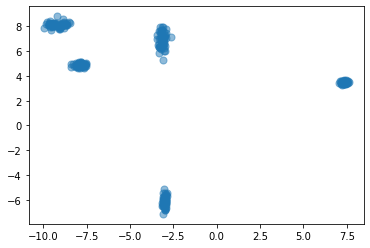

In [8]:
plt.scatter(
    x=points[:, 0],
    y=points[:, 1],
    s=50,
    alpha=0.5
)
plt.show()

In [9]:
batch_size = 32
dataset = get_dataset(points, batch_size=batch_size)

In [10]:
dataset_iter = iter(dataset)
dataset_points_list = [
    dataset_iter.next() for _ in range(num_points // batch_size)
]
if num_points % batch_size > 0:
    dataset_points_list += [dataset_iter.next()[:num_points % batch_size]]
dataset_points_arr = np.concatenate(dataset_points_list, axis=0)

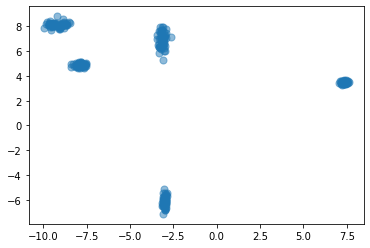

In [11]:
plt.scatter(
    x=dataset_points_arr[:, 0],
    y=dataset_points_arr[:, 1],
    s=50,
    alpha=0.5
)
plt.show()

In [12]:
kmeans = KMeansClustering(
    num_points=num_points,
    num_dims=num_dims,
    num_clusters=3,
    max_iterations=10,
    centroid_initialization_method="kmeans++"
)

In [13]:
kmeans.kmeans_clustering(
    dataset=dataset, batch_size=batch_size, print_iteration_info=True
)

Iteration 0 has 32977.19921875 loss.
Iteration 1 has 11899.9697265625 loss.
Iteration 2 has 9047.783203125 loss.
Iteration 3 has 6822.17578125 loss.
Iteration 4 has 6821.53955078125 loss.
Iteration 5 has 6821.53955078125 loss.


In [14]:
kmeans.centroids

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[-5.5125546,  5.909492 ],
       [-9.205384 ,  8.114607 ],
       [ 2.1609306, -1.3191011]], dtype=float32)>

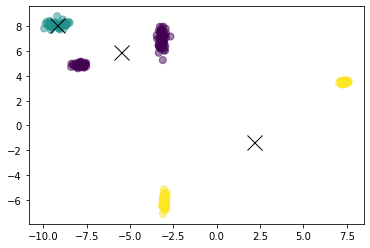

In [15]:
kmeans.find_closest_centroid_assignments(dataset_points_arr)
plt.scatter(
    x=dataset_points_arr[:, 0],
    y=dataset_points_arr[:, 1],
    c=kmeans.assignments,
    s=50,
    alpha=0.5
)
plt.plot(
    kmeans.centroids[:, 0].numpy(),
    kmeans.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()

In [16]:
optimal_kmeans = OptimalKMeansClustering(
    batch_size=batch_size,
    num_points=num_points,
    num_dims=num_dims,
    real_dataset=dataset,
    max_clusters=10,
    max_iterations=100,
    centroid_initialization_method="kmeans++",
    num_reference_datasets=10
)

In [17]:
optimal_kmeans.find_optimal_k()


k = 1
Performing kmeans on real points!
Iteration 0 has 34818.7890625 loss.
Iteration 1 has 17836.515625 loss.
Iteration 2 has 17836.515625 loss.
Performing kmeans on reference points!

k = 2
Performing kmeans on real points!
Iteration 0 has 34814.5546875 loss.
Iteration 1 has 12798.107421875 loss.
Iteration 2 has 9428.3876953125 loss.
Iteration 3 has 7562.18896484375 loss.
Iteration 4 has 7561.5205078125 loss.
Iteration 5 has 7561.52099609375 loss.
Performing kmeans on reference points!

k = 3
Performing kmeans on real points!
Iteration 0 has 33455.3046875 loss.
Iteration 1 has 8802.048828125 loss.
Iteration 2 has 5030.630859375 loss.
Iteration 3 has 1641.4266357421875 loss.
Iteration 4 has 1582.16943359375 loss.
Iteration 5 has 1582.16943359375 loss.
Performing kmeans on reference points!

k = 4
Performing kmeans on real points!
Iteration 0 has 33425.86328125 loss.
Iteration 1 has 11661.5380859375 loss.
Iteration 2 has 8840.91796875 loss.
Iteration 3 has 6357.4208984375 loss.
Iterat

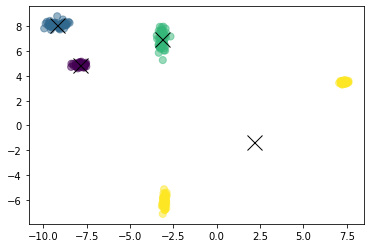

In [18]:
optimal_kmeans.best_model.find_closest_centroid_assignments(
    dataset_points_arr
)
plt.scatter(
    x=dataset_points_arr[:, 0],
    y=dataset_points_arr[:, 1],
    c=optimal_kmeans.best_model.assignments.numpy(),
    s=50,
    alpha=0.5
)
plt.plot(
    optimal_kmeans.best_model.centroids[:, 0].numpy(),
    optimal_kmeans.best_model.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()